In [ ]:
#get dataframe of tweet_id and user_id
import pandas
import csv
from twython import Twython
import time
from collections import defaultdict

df = pandas.read_csv('gamergate_tweets.csv')
user_ids = df['user_id'].tolist()[:5000]

# Consumer & Auth keys and tokens for authentication
CONSUMER_KEY = "48r56upQvsnTiSDfY4CNwIpCQ"
CONSUMER_SECRET = "VqZhFW7GqogdKXJnpuS0umVe211bFgoCdaQlRdRMayvrbdDh3k"
OAUTH_TOKEN = "18000528-Scl8a1pLinqP4KWtaa3f8EN0M1vqAGTyYXMtsLIGm"
OAUTH_TOKEN_SECRET = "NcIvLeqVbwwBegabvo7946FVIaDN0CAaJ7aS2aV7pZFzC"

twitter = Twython(
    CONSUMER_KEY, CONSUMER_SECRET,
    OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

# check rate limit
# twitter.get_application_rate_limit_status()['resources']['followers']

In [47]:
# GET followers/list
def get_follower_list(twitter, user_id):
    followers = []
    cursored = twitter.cursor(twitter.get_followers_list, id=user_id)
    for follower in cursored:
        followers.append(follower)
    return followers

# GET users/lookup
def get_user_lookup(twitter, current):
    user_obj = twitter.lookup_user(user_id=current)
    return user_obj
    
# GET followers/ids
def get_follower_ids(twitter, user_id):
    followers = []
    cursored = twitter.cursor(twitter.get_followers_ids, id=user_id)
    for follower in cursored:
        followers.append(follower)
    return followers

In [ ]:
user_list = []
start = 0
end = 100
while end <= 5000:
    current = user_ids[start:end]
    start += 100
    end += 100
    users = get_user_lookup(twitter, current)
    for i in range(0, len(users)):
        each_user = []
        each_user.append(user_ids[i]) # user[0] = user_id
        each_user.append(users[i]['followers_count']) # user[1] = follower count
        each_user.append(users[i]["favourites_count"])
        user_list.append(each_user)

         User ID  Retweets  Favorites  Has_url  \
0       20708129       363          0        0   
1       20945241         1          0        0   
2      251045973         0          0        0   
3     1091189214         1          0        0   
4     2847688135         0          0        1   
5     2798609018         0          0        0   
6     2492324996       794          0        1   
7       93363347       238          0        1   
8      937178150        27          0        0   
9       36790442         0          0        1   
10    2590712055        33          0        1   
11      16326705       970          0        0   
12     985889652        80          0        1   
13      18746944       238          0        1   
14     162572003         0          1        0   
15     940132086       229          0        0   
16      49534986        19          0        0   
17     171848975         0          0        0   
18      49724410         0          0        0   


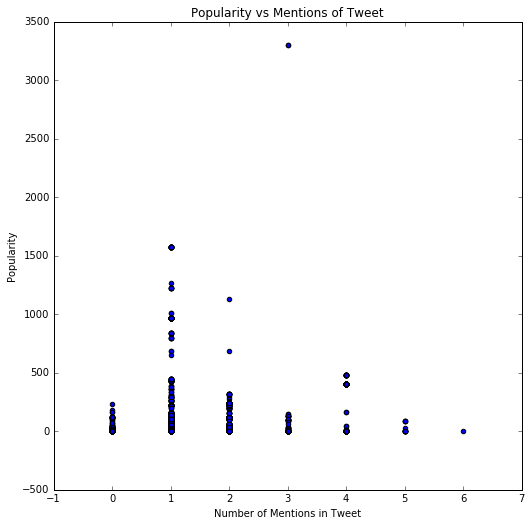

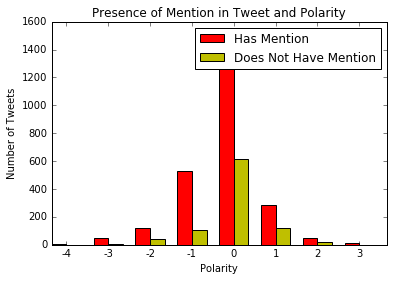

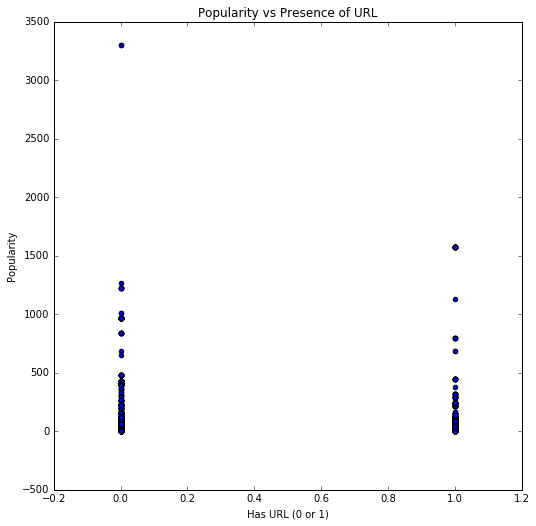

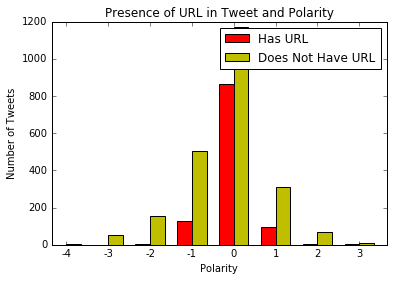

In [116]:
users_df = pandas.DataFrame(user_list, columns=["User ID", "Follower Count", "Favourites Count"])
%run Get\ Tweets.ipynb
#print users_df.sort_values(["Follower Count", "Favourites Count",], ascending=[False, False])

In [237]:
polar_user_df = tweets_df.loc[tweets_df['Polarity'].isin([-4, 3])]
pop_user_df = tweets_df.sort_values('Popularity', ascending=False)[:20]
polar_user_df.drop(['Text', 'Has_url', 'Retweets', 'Favorites'], axis=1, inplace=True)
polar_users = polar_user_df['User ID']

/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [254]:
print polar_user_df.info()
follower_ids = defaultdict(list)
i = 0
remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/list']['remaining']
while i < len(polar_users):
    print polar_users[i]
    if remaining < 1:
        print "start waiting"
        time.sleep(930)
        print "done waiting"
        remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
        print remaining, polar_users[i]
    else:
        follower_ids[polar_users[i]] = get_follower_list(twitter, polar_users[i])
        remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/list']['remaining']
        print remaining, polar_users[i]
        i += 1

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 1468 to 2449
Data columns (total 6 columns):
User ID                   21 non-null int64
Mentions                  21 non-null object
User Polarity             21 non-null int64
Popularity                21 non-null int64
Follower Tweets Count     21 non-null int64
Follower Polarity Mean    20 non-null float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.1+ KB
None


TwythonRateLimitError: Twitter API returned a 429 (Too Many Requests), Rate limit exceeded

In [ ]:
# TODO follower_id is missing one user, 
# I added it manuelly right now b/c I'm being lazy 
# but this need to be fixed later
print len(follower_ids.keys())
# find out tweets that belongs to followers of the 21 popular users
# make a df of all the tweets for each popular user
follower_dfs = []
for p in polar_users:
    df = tweets_df.loc[tweets_df['User ID'].isin(follower_ids[p])]
    follower_dfs.append(df)
    

In [249]:
# pay attention to 574962273, 1499808391, 854203626
count_list = []
polar_mean = []
for i in range(len(follower_dfs)):
    count_list.append(follower_dfs[i].shape[0])
    polar_mean.append(follower_dfs[i].Polarity.mean())

polar_user_df["Follower Tweets Count"] = np.array(count_list)
polar_user_df["Follower Polarity Mean"] = np.array(polar_mean)
print polar_user_df.info()

/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 1468 to 2449
Data columns (total 6 columns):
User ID                   21 non-null int64
Mentions                  21 non-null object
Polarity                  21 non-null int64
Popularity                21 non-null int64
Follower Tweets Count     21 non-null int64
Follower Polarity Mean    20 non-null float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.1+ KB
None


In [223]:
for i in range(len(follower_dfs)):
    print 

-0.143939393939


In [251]:
polar_user_df.rename(index=str, columns={"Polarity": "User Polarity"}, inplace=True)

,User ID,Mentions,User Polarity,Popularity,Follower Tweets Count,Follower Polarity Mean
1468,2368624716,"[6160792, 56768257]",-4,192,3,-0.333333
2835,16088388,[],-4,0,0,NaN
1773,2801289353,"[6160792, 56768257]",-4,192,222,-0.297297
3374,1317712621,"[6160792, 56768257]",-4,192,85,-0.094118
2521,1498976455,[],-4,0,372,-0.147849
2355,574962273,[8772882],3,3,91,-0.131868
1022,104519838,[109741789],3,0,13,-0.153846
1979,2790717530,[2824635320],3,3,208,-0.158654
1353,2788941283,"[1499808391, 10380732]",3,1,293,-0.126280
1358,2837175356,"[471633263, 135262296, 8936082]",3,0,924,-0.143939
